# Face Authentication Attendance — Analytics Dashboard

Loads attendance data (SQLite or CSV), computes daily working hours, and visualizes punch patterns.

In [15]:
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Prefer CSV backend for notebook (use CSV if present)
os.environ.setdefault("ATTENDANCE_STORAGE", "csv")

# Project root
ROOT = Path(".").resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from utils import get_storage
from attendance import get_attendance_summary, sessions_for_date, total_working_hours_for_date

In [ ]:
import os
# Force CSV backend before loading storage
os.environ["ATTENDANCE_STORAGE"] = "csv"

import pandas as pd
from utils import get_storage
import importlib, utils
importlib.reload(utils)

storage = utils.get_storage()
print("Backend:", type(storage).__name__)
storage.init_schema()
records = storage.get_records()
df = pd.DataFrame(records)
if df.empty:
    df = pd.DataFrame(columns=["user_id", "name", "punch_type", "timestamp", "session_minutes"])
else:
    df["timestamp"] = pd.to_datetime(df["timestamp"]) 
    df["date"] = df["timestamp"].dt.date

df.head(20)

,user_id,name,punch_type,timestamp,session_minutes,date
0,EMP001,Jane Doe,in,2026-02-03 01:10:39.290933,None,2026-02-03


## Daily working hours per user

In [17]:
if not df.empty and "user_id" in df.columns:
    users = df["user_id"].unique()
    daily = []
    for uid in users:
        name = df[df["user_id"] == uid]["name"].iloc[0] if len(df[df["user_id"] == uid]) else uid
        dates = df[df["user_id"] == uid]["date"].unique()
        for d in dates:
            hours = total_working_hours_for_date(uid, d)
            daily.append({"user_id": uid, "name": name, "date": d, "hours": hours})
    daily_df = pd.DataFrame(daily)
    display(daily_df)
else:
    daily_df = pd.DataFrame(columns=["user_id", "name", "date", "hours"])
    print("No attendance records yet.")

,user_id,name,date,hours
0,EMP001,Jane Doe,2026-02-03,0.0


In [18]:
from utils import list_registered_users
users = list_registered_users()
user_df = pd.DataFrame(users)

if 'df' in globals() and not df.empty:
    # Ensure timestamps are datetimes
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    counts = df['user_id'].value_counts().to_dict()
    last = df.sort_values('timestamp').groupby('user_id').last()
    last_ts = last['timestamp'].to_dict() if 'timestamp' in last.columns else {}
    last_pt = last['punch_type'].to_dict() if 'punch_type' in last.columns else {}

    user_df['total_punches'] = user_df['user_id'].map(lambda uid: counts.get(uid, 0))
    user_df['last_punch_time'] = user_df['user_id'].map(lambda uid: last_ts.get(uid, pd.NaT))
    user_df['last_punch_type'] = user_df['user_id'].map(lambda uid: last_pt.get(uid, ''))
else:
    user_df['total_punches'] = 0
    user_df['last_punch_time'] = pd.NaT
    user_df['last_punch_type'] = ''

user_df['has_attendance'] = user_df['total_punches'] > 0
display(user_df.sort_values(['has_attendance', 'total_punches'], ascending=[False, False]))

,user_id,name,total_punches,last_punch_time,last_punch_type,has_attendance
0,EMP001,Jane Doe,1,2026-02-03 01:10:39.290933,in,True
1,EMP01,MD HAJI,0,NaT,,False
2,EMP02,ABD,0,NaT,,False
3,EMP03,md sohail,0,NaT,,False
4,EMP06,jon snow,0,NaT,,False


## Punch-in / Punch-out distribution by hour

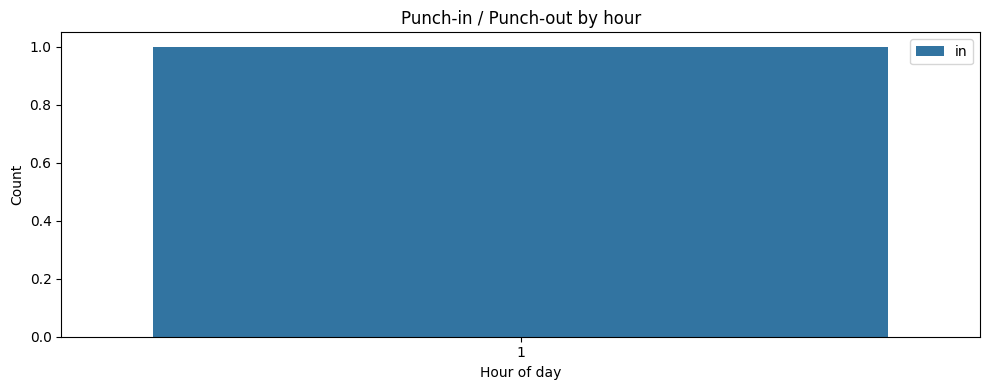

In [19]:
if not df.empty and "timestamp" in df.columns:
    df["hour"] = df["timestamp"].dt.hour
    fig, ax = plt.subplots(figsize=(10, 4))
    punch_hr = df[df["punch_type"].str.lower().isin(["in", "out"])].copy()
    punch_hr["punch_type"] = punch_hr["punch_type"].str.lower()
    sns.countplot(data=punch_hr, x="hour", hue="punch_type", ax=ax)
    ax.set_xlabel("Hour of day")
    ax.set_ylabel("Count")
    ax.legend()
    ax.set_title("Punch-in / Punch-out by hour")
    plt.tight_layout()
    plt.show()
else:
    print("No data to plot.")

## Total hours per user (all time)

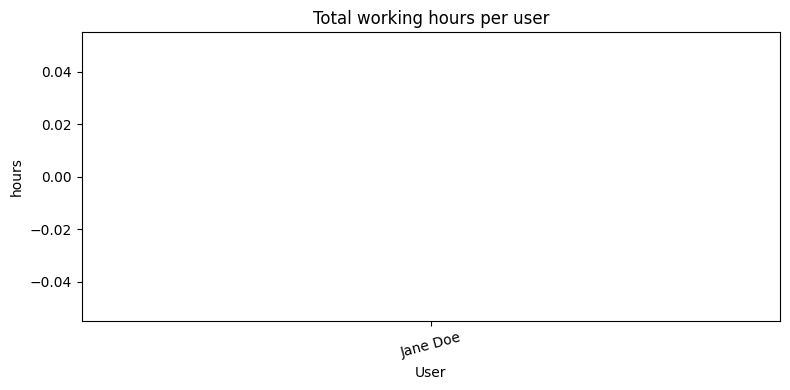

In [20]:
if not daily_df.empty:
    user_hours = daily_df.groupby(["user_id", "name"])["hours"].sum().reset_index()
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.barplot(data=user_hours, x="name", y="hours", ax=ax)
    ax.set_title("Total working hours per user")
    ax.set_xlabel("User")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()
else:
    print("No daily data.")